# Example of Staging Upload to ImageCalc Table
This notebook goes through an example of uploading a classified planet image, a logfile, and training data to the DSWx calval database. Data files and metadata are uploading to a staging bucket. Then, the database manager will commit these uploads to the database

In [1]:
import geopandas as gpd
import pandas as pd
import boto3
import os
from datetime import datetime
import sys
sys.path.insert(0, './tools/')
from addImageCalc import addImageCalc
from pathlib import Path
import rasterio
from shapely.geometry import box
from rasterio.crs import CRS
from rasterio.warp import transform_bounds

YOU NEED TO FILL THESE OUT!

In [3]:
#Name of person who reviewed the classification. Leave as "None" if classification has not been reviewed
reviewer_name = 'None' 

#Usually 'Mannual classification' or 'Review'
calc_type = 'Mannual classification' 

#Either 'Intermediate' or 'Final' if review is classification passed review with no changes
processing_level = 'Intermediate' 

#Processing notes. e.g. 'Supervised classification using 
# SCP mannual edits using Serval informed by Pekel water mask'
notes = 'Classified using SCP and manual edits with Serval. Only one water body in image'

# Who made the classification - else specify "review"
editor_name = 'Matthew Bonnema' 

fields = [editor_name, notes, processing_level, calc_type, reviewer_name]
if any([not f for f in fields]):
    raise ValueError

In [4]:
#Only specify one. Leave the other as ''. If more than one planet image for given chip, PLANET_ID must be specified 
PLANET_ID = ''
SITE_NAME = '3_32'
assert((len(PLANET_ID) == 0) ^ (len(SITE_NAME) == 0))

### AWS Credentials
In order to download imagery from the private bucket, JPL RSA access and OPERA Calval AWS credenitals are needed

In [5]:
bucket_name = 'opera-calval-database-dswx'
session = boto3.session.Session(profile_name='saml-pub')
s3 = session.resource('s3')
s3_client = session.client('s3')

### Read Image metadata table
To get the geometry metadata for the classified image. Make sure we connect `site_name` and `planet_id` correctly.

In [6]:
imageTable = gpd.read_file(s3.Object(bucket_name,'image.geojson').get()['Body'])
imagecalcTable = gpd.read_file(s3.Object(bucket_name,'image_calc.geojson').get()['Body'])

In [7]:
temp = imageTable[['image_name', 'site_name']]
df_site2image = temp.set_index('site_name')
df_image2site = temp.set_index('image_name')

In [8]:
# This cell will show the number of planet images found for a given chip. If more than one, ensure the printed Planet
# ID matches the planet image used to generate the classification
if not PLANET_ID:
    values = PLANET_ID = df_site2image.loc[SITE_NAME].tolist()
    PLANET_ID = values[0]
    print(f'There was {len(values)} planet images for this chip')
else:
    values = df_image2site.loc[PLANET_ID].tolist()
    SITE_NAME = values[0]
    print(f'There were {len(values)} chips for this planet_image')

(SITE_NAME, PLANET_ID)

There was 1 planet images for this chip


('3_32', '20211028_063039_20_2429')

In [9]:
search = imageTable[imageTable.image_name == PLANET_ID]
planet_image = search.iloc[[0]]
geometry = planet_image.geometry.iloc[0]

Versioning simply increments to maximum version. If you downloaded imagery. Should have a metadata file from previous run.

In [10]:
# This cell assigns a version number to the classification. If this is the first classification of a given planet
# image, the assigned version should be 0. Otherwise, it will increment on the latest version found in the database
search = imagecalcTable[imagecalcTable.image_name == PLANET_ID]
prev_version = -1
if len(search) == 0:
    previous_name = None
    print('No previous versions found')
else:
    try:
        prev_version = search['version'].max() 
        previous_name = search[search.version==search['version'].max()].image_calc_name.iloc[0]
        print('Previous version = '+str(prev_version))
    except:
        previous_name = None
        print('Older versions found, but could not identify version number')

No previous versions found


# Check Previous Metadata or write new

In [11]:
imagecalc_metadata_path = Path(f'planet_images_cropped/{PLANET_ID}/metadata_{PLANET_ID}_v{prev_version}.geojson')
imagecalc_metadata_prev = {}
if imagecalc_metadata_path.exists():
    df_metadata = gpd.read_file(imagecalc_metadata_path)
    imagecalc_metadata_prev = df_metadata.to_dict('records')[0]
    
imagecalc_metadata_prev

{}

In [12]:
if imagecalc_metadata_path.exists():
    editor_name =  imagecalc_metadata_prev['calculated_by']
    print(f'Uploading the previous editor name ({editor_name})')
    
    notes = f'Previous({imagecalc_metadata_prev["notes"]}) {notes}'
    print(f'Notes: {notes}')
    
else:
    if not editor_name:
        raise ValueError('Update editor name in previous cell')
    

# Read Image

In [23]:
#Local directory where classification file(s) are located
uploadDir = Path(f'planet_images_cropped/{PLANET_ID}').absolute()

#Name of classified geotif
classified_image_filename = f'classification_finished_{PLANET_ID}.tif' 

#Uncomment if logfile exists and esnure it is included in filePaths below before upload
#log_filename = 'logfile.txt 

#Uncomment if uploading any additional files and esnure they are included in filePaths below before upload
#additional_filename = 'additional_file.txt' 

assert((uploadDir / classified_image_filename).exists())

# Compute Stratum

In [24]:
with rasterio.open(uploadDir / classified_image_filename) as ds:
    water_mask = ds.read(1)
    nodata = ds.nodata
    classified_profile = ds.profile
    bounds = ds.bounds
    
data_mask = (water_mask != nodata)
water_frac = (water_mask == 1).sum() / data_mask.sum()
print(f'Fraction of water is {water_frac: 1.3f}')

Fraction of water is  0.001


In [25]:
import numpy as np

bins = [0, .0008, .02, 1]
def stratify(water_frac):
    return np.digitize(water_frac, bins, right=True)
water_stratum = stratify(water_frac)
water_stratum

2

In [26]:
# Example
print('Strata for percent water x')
print(f'Strata 0: =={bins[0]}%')
print(f'Strata 1: {bins[0] * 100} < x <= {bins[1] * 100}%')
print(f'Strata 2: {bins[1] * 100} < x <= {bins[2] * 100}%')
print(f'Strata 3: x > {bins[2] * 100}%')

print()
print('Example')
for pw in [0, 0.0001, 0.0008, 0.001, 0.01, .03]:
    ind = stratify(pw)
    print(f'Area with {pw*100}% water is in strata {ind}')

Strata for percent water x
Strata 0: ==0%
Strata 1: 0 < x <= 0.08%
Strata 2: 0.08 < x <= 2.0%
Strata 3: x > 2.0%

Example
Area with 0% water is in strata 0
Area with 0.01% water is in strata 1
Area with 0.08% water is in strata 1
Area with 0.1% water is in strata 2
Area with 1.0% water is in strata 2
Area with 3.0% water is in strata 3


# Datatypes

Let's make sure everything is in the right format.

1. nodata = 255 (easier gdal reads)
2. only values [0, 1, 7, 255] with

+ 0 = no water
+ 1 = water
+ 7 = will not classify
+ 255 = no data

Can make this conditional flow `False` if you are annoyed by this additional check.

In [27]:
if True:
    with rasterio.open(uploadDir / classified_image_filename) as ds:
        water_mask = ds.read(1)
        nodata = ds.nodata

    assert(nodata == 255)

    vals = set(np.unique(water_mask))
    assert(vals.issubset(set([0, 1, 7, 255])))

    assert(water_mask.dtype == 'uint8')

Should you want to either update nodata or dtype, change to True. Will update your data to append a `_formatted` suffix to the file name.

In [28]:
if False:
    classified_image_filename_old = classified_image_filename
    classified_image_filename = classified_image_filename.replace('.tif', '_formatted.tif')
    
    p = classified_profile.copy()
    p['nodata'] = 255
    p['dtype'] = np.uint8
    with rasterio.open(uploadDir / classified_image_filename, 'w', **p) as ds:
        ds.write(water_mask.astype(np.uint8), 1)

## Get the polygon in 4326

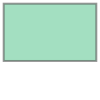

In [29]:
# Classified Image read and geometry

with rasterio.open(uploadDir / classified_image_filename) as ds:
    bounds = ds.bounds
    crs_utm = ds.crs
    
bounds_4326 = transform_bounds(crs_utm, CRS.from_epsg(4326), *bounds)
classified_geometry = box(*bounds_4326)
classified_geometry

### Enter the required file locations and metadata fields
To upload the classified image, we need to specify its location on the local computer (and the location of auxilary files). We also need to fill in some metadata fields. Both file paths and metadata are specified as dictionaries

In [30]:
filePaths = {
    'image_calc' : str(uploadDir  / classified_image_filename),
    #'logfile' : uploadDir + log_filename, #uncomment this line if uploading logfile
    #additional_file: additional_file_name #uncomment this line if uploading additional file
}
filePaths

{'image_calc': 'c:\\Users\\Matthew Bonnema\\OneDrive\\Documents\\OPERA\\DSWx\\DSWx-Validation-Dataset-Generation\\planet_images_cropped\\20211028_063039_20_2429\\classification_finished_20211028_063039_20_2429.tif'}

In [31]:
metaData = {
    'image_name':planet_image.image_name.iloc[0], #str
    'image_calc_name':planet_image.image_name.iloc[0]+'_classification', #str 
    'calc_type':calc_type, #str 
    'processing_level':processing_level, #str
    'oversight_level':None, #str,
    'calculated_by': editor_name, #str
    'reviewed_by': reviewer_name, #str
    'notes' : notes,
    'public':True, #bool
    'water_stratum': water_stratum,
    'geometry': classified_geometry, #shapely geometry
}
metaData

{'image_name': '20211028_063039_20_2429',
 'image_calc_name': '20211028_063039_20_2429_classification',
 'calc_type': 'Mannual classification',
 'processing_level': 'Intermediate',
 'oversight_level': None,
 'calculated_by': 'Matthew Bonnema',
 'reviewed_by': 'None',
 'notes': 'Classified using SCP and manual edits with Serval. Only one water body in image',
 'public': True,
 'water_stratum': 2,
 'geometry': <shapely.geometry.polygon.Polygon at 0x132726b79a0>}

### Stage the image
We use a pre-defined function to upload files and metadata to the staging area. This function takes the file paths and metadata dictionaries, as well as the AWS session object as inputs

    

In [32]:
addImageCalc(filePaths,metaData,session)

Creating geojson table
Uploading geojson table
Uploading files
staging complete


'pending/20220927_135308_imagecalc.geojson'